<a href="https://colab.research.google.com/github/alirezash97/Galaxy-Classification/blob/master/Galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install pillow

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras import Model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [166]:
base_dir = '/content/drive/My Drive/Galaxy Classification'
trainset_dir = os.path.join(base_dir, 'trainset')
trainset_fnames = os.listdir(trainset_dir)
print(trainset_fnames)

['ssc2019-15b_med.jpg', 'm51better-2.jpeg', 'd_mach_milkywayshape_190205.jpg']


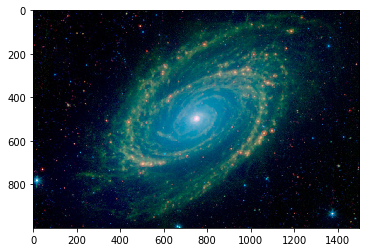

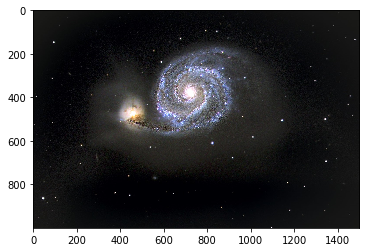

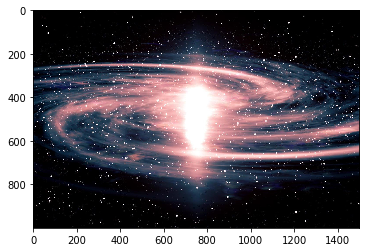

In [167]:
trainset_images = [os.path.join(trainset_dir, fname) 
                for fname in trainset_fnames[:]]

x = []
for img_path in trainset_images:

  img = mpimg.imread(img_path)
  x.append(img)
  plt.imshow(img)
  plt.show()
m = len(x)


In [189]:
layer1 = []
for image in x:
  for i in range(3):
    for j in range(2):
      mask = np.random.choice([0, 1], size=(998,1498), p=[3./10, 7./10])
      print(j)
      a = 1498+j 
      img = image[i:i+998][0]
      print(img.shape)
      temp = np.dot(img, mask)
      layer1.append(temp)

prinr(len(layer1))
# print(mask)
# for image in x:
#   for i in range(4):


0
<class 'numpy.ndarray'>
(1500, 3)


ValueError: ignored

In [0]:
x = np.array(x).reshape((m, 4500000))

In [0]:
class NeuralNetwork:


  def __init__(self, layers, learning_rate, x, y):
    self.layers = layers
    self.learning_rate = learning_rate
    self.x = x
    self.y = y
  
  

  
  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))
  

  
  def initialization(self):
    for i in range(1, len(self.layers)):
        w0 = globals()['w%s' % 0] = np.zeros((self.x.shape[1], self.layers[0]))
        b0 = globals()['b%s' % 0] = np.ones((self.layers[0], 1))
        globals()['w%s' % i] = np.zeros((self.layers[i-1], self.layers[i]))
        globals()['b%s' % i] = np.ones((self.layers[i], 1))
    globals()['w%s' % (len(self.layers))] = np.zeros((self.layers[i], 1))
    globals()['b%s' % (len(self.layers))] = np.ones((1, 1))
    return None
    
  
  def forwardPropagation(self):
    for i in range(2, len(self.layers) + 1):
      globals()['z%s' % 1] = np.dot(self.x, globals()['w%s' % 0]) + globals()['b%s' % 0].T
      globals()['a%s' % 1] = self.sigmoid(globals()['z%s' % 1])
      globals()['z%s' % i] = np.dot(globals()['a%s' % (i-1)], globals()['w%s' % (i-1)]) + globals()['b%s' % (i-1)].T
      globals()['a%s' % i] = self.sigmoid(globals()['z%s' % i])
      if i == (len(self.layers)) :
        globals()['z%s' % (len(self.layers) + 1)] = np.dot(globals()['a%s' % (i)], globals()['w%s' % (i)]) + globals()['b%s' % (i)].T
        globals()['a%s' % (len(self.layers) + 1)] = self.sigmoid(globals()['z%s' % (len(self.layers) + 1)])
    return None

  def backpropagation(self):
    
    
    globals()['da%s' % (len(self.layers) + 1)] = 0
    for j in range(self.x.shape[0] - 1 ):
      globals()['da%s' % (len(self.layers) + 1)] += ( -y[j] / globals()['a%s' % (len(self.layers) + 1)][j] ) + ( (1 - y[j]) / (1 - globals()['a%s' % (len(self.layers) + 1)][j]) )
    # globals()['dz%s' % len(self.layers) + 1)] = globals()['da%s' % len(self.layers) + 1)] * sigmoid()
    

  
  def output(self):
    print("\n", self.x)
    for i in range(1, len(self.layers) + 2):
      print("\n", globals()['z%s' % i])
      print("\n", globals()['a%s' % i])
    print(" i am da for last layer", globals()['da%s' % (len(self.layers) + 1)])
    return None


#############################
neural = NeuralNetwork([4, 3, 2], 0.15, np.array([[1, 5, 3], [4, 6, 1], [9, 1, 5]]), [0, 1, 1])
neural.initialization()
neural.forwardPropagation()
neural.backpropagation()
neural.output()
##############################
